In [4]:
import numpy as np
import json
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import multiprocessing
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import pickle
import os
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import mne_bids
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import io
from scipy import stats
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.spectra import plot_spectrum
from neurodsp import sim
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum_welch
from neurodsp.plts import plot_time_series, plot_power_spectra
from fooof.bands import Bands

import statsmodels.api as sm
import statsmodels.formula.api as smf
# gradient boosted trees tend to do well on problems like this

BIDS_path = 'C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
#out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'

faces = io.loadmat('..\\..\\icn_plots\\faces.mat')
Vertices = io.loadmat('..\\..\\icn_plots\\Vertices.mat')
grid = io.loadmat('..\\..\\icn_plots\\grid.mat')['grid']
stn_surf = io.loadmat('..\\..\\icn_plots\\STN_surf.mat')
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

def get_coord_all(l_choords_ecog_con):
    x_ = []; y_ = []
    for patient_idx in range(len(l_choords_ecog_con)):
        x_.append(np.array(l_choords_ecog_con[patient_idx])[0,:])
        y_.append(np.array(l_choords_ecog_con[patient_idx])[1,:])
    return np.concatenate(np.array(x_)), np.concatenate(np.array(y_))

In [16]:
df = pd.read_csv("..\\UPDATE_NEWCV_PLOTS\\df_all.csv",index_col=[0])

In [17]:
df

,ch,dist_con,dist_ips,loc,r2_con,r2_ips,sess_,sub,x,y,z,b_peak,UPDRS_rigidity_upper_extrimity_contralateral,UPDRS_rigidity_upper_extrimity_ipsilateral,UPDRS_combined_akinesia_rigidty_contalateral,UPDRS_combined_akinesia_rigidty_ipsilateral,UPDRS_total
0,ECOG_RIGHT_0,23.714756,23.714756,ECOG,0.658060,0.418974,right,0,37.318174,-48.610127,61.797655,3.004269,1,1,6.0,7,28
1,ECOG_RIGHT_1,12.718657,12.718657,ECOG,0.711734,0.415419,right,0,40.159894,-37.315930,64.311716,4.356077,1,1,6.0,7,28
2,ECOG_RIGHT_2,4.524949,4.524949,ECOG,0.549021,0.308202,right,0,40.943036,-27.217785,64.095184,3.654367,1,1,6.0,7,28
3,ECOG_RIGHT_3,8.466679,8.466679,ECOG,0.623977,0.375705,right,0,39.783955,-17.005231,63.866181,3.849308,1,1,6.0,7,28
4,ECOG_RIGHT_4,19.792789,19.792789,ECOG,0.571970,0.246979,right,0,39.688136,-5.528025,61.682543,2.562056,1,1,6.0,7,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,STN_LEFT_1,6.166394,6.166394,STN,0.000000,0.000000,left,13,-14.888300,-17.947000,-9.350200,0.000000,3,2,17.0,12,48
244,STN_LEFT_2,4.984300,4.984300,STN,0.000000,0.000000,left,13,-15.504000,-17.212900,-7.223300,0.000000,3,2,17.0,12,48
245,STN_RIGHT_0,3.085589,3.085589,STN,0.000000,0.000000,right,14,14.812955,-14.134391,-3.867494,0.000000,1,2,6.0,8,31
246,STN_RIGHT_1,4.695180,4.695180,STN,0.000000,0.000000,right,14,15.164177,-13.053698,-1.966183,0.089447,1,2,6.0,8,31


### ECOG 

In [64]:
df_6A = pd.DataFrame()

for sub in subject_id:
    for hem in ["right", "left"]:
        df_here = df[df["loc"].str.contains("ECOG")]
        df_here = df_here[df_here["sub"] == int(sub)]
        df_here = df_here[df_here["sess_"].str.contains(hem)].reset_index()
        if df_here.shape[0] == 0:
            continue
        min_dist = df_here.dist_con.argmin()
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":"ips",
            "x":df_here.loc[min_dist]["x"], 
            "y":df_here.loc[min_dist]["y"], 
            "mod":"closest",
            "sub":sub, 
            "loc":"ECOG"
        }, ignore_index=True)
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":"con",
            "x":df_here.loc[min_dist]["x"], 
            "y":df_here.loc[min_dist]["y"], 
            "mod":"closest",
            "sub":sub,
            "loc":"ECOG"
        }, ignore_index=True)
            
        for lat in ["con", "ips"]:
            lat_ = "r2_"+lat
            max_per = df_here[lat_].argmax()
            df_6A = df_6A.append({
                "hem":hem, 
                "lat":lat,
                "x":df_here.loc[max_per]["x"], 
                "y":df_here.loc[max_per]["y"], 
                "mod":"best",
                "sub":sub,
                "loc":"ECOG"
            }, ignore_index=True)
                

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [65]:
df_6A

,hem,lat,loc,mod,sub,x,y
0,right,ips,ECOG,closest,000,40.943036,-27.217785
1,right,con,ECOG,closest,000,40.943036,-27.217785
2,right,con,ECOG,best,000,40.159894,-37.315930
3,right,ips,ECOG,best,000,37.318174,-48.610127
4,right,ips,ECOG,closest,001,36.636654,-26.376084
...,...,...,...,...,...,...,...
59,left,ips,ECOG,best,013,-36.977937,-2.737176
60,right,ips,ECOG,closest,014,22.392009,-16.877652
61,right,con,ECOG,closest,014,22.392009,-16.877652
62,right,con,ECOG,best,014,27.318273,-7.758095


In [66]:
choord_closest_ECOG_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "ECOG")][["x", "y"]])
choord_closest_ECOG_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "ECOG")][["x", "y"]])
choord_best_ECOG_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "best")& (df_6A["loc"] == "ECOG")][["x", "y"]])
choord_best_ECOG_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "best")& (df_6A["loc"] == "ECOG")][["x", "y"]])

In [67]:
for sub in subject_id:
    for hem in ["right", "left"]:
        #df_here = df[df["loc"].str.contains("STN")]
        #df_here = df_here[df_here["bids_id"].str.contains(sub)]
        #df_here = df_here[df_here["hemisphere"].str.contains(hem)].reset_index()
        
        df_here = df[df["loc"].str.contains("STN")]
        df_here = df_here[df_here["sub"] == int(sub)]
        df_here = df_here[df_here["sess_"].str.contains(hem)].reset_index()
        
        
        if df_here.shape[0] == 0:
            continue
        min_dist = df_here.dist_con.argmin()
        
        if min_dist == 0:
            x_ = (np.array(df_here[["x", "y"]])[1,0] + np.array(df_here[["x", "y"]])[0,0])/2
            y_ = (np.array(df_here[["x", "y"]])[1,1] + np.array(df_here[["x", "y"]])[0,1])/2
        if min_dist == 1:
            x_ = (np.array(df_here[["x", "y"]])[1,0] + np.array(df_here[["x", "y"]])[2,0])/2
            y_ = (np.array(df_here[["x", "y"]])[1,1] + np.array(df_here[["x", "y"]])[2,1])/2
        if min_dist == 2:
            try:
                x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[3,0])/2
                y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[3,1])/2
            except:
                    x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[1,0])/2
                    y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[1,1])/2

        if min_dist == 3:
            try:
                x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[3,0])/2
                y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[3,1])/2
            except:
                x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[1,0])/2
                y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[1,1])/2

        
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":lat,
            "x":x_, 
            "y":y_, 
            "mod":"closest",
            "sub":sub,
            "loc":"STN"
        }, ignore_index=True)
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":"con",
            "x":x_, 
            "y":y_, 
            "mod":"closest",
            "sub":sub,
            "loc":"STN"
        }, ignore_index=True)
            
        for lat in ["con", "ips"]:
            lat_ = "r2_"+lat
            max_per = df_here[lat_].argmax()
            
            if max_per == 0:
                x_ = (np.array(df_here[["x", "y"]])[1,0] + np.array(df_here[["x", "y"]])[0,0])/2
                y_ = (np.array(df_here[["x", "y"]])[1,1] + np.array(df_here[["x", "y"]])[0,1])/2
            if max_per == 1:
                x_ = (np.array(df_here[["x", "y"]])[1,0] + np.array(df_here[["x", "y"]])[2,0])/2
                y_ = (np.array(df_here[["x", "y"]])[1,1] + np.array(df_here[["x", "y"]])[2,1])/2
            if max_per == 2:
                try:
                    x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[3,0])/2
                    y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[3,1])/2
                except:
                    x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[1,0])/2
                    y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[1,1])/2

            if max_per == 3:
                try:
                    x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[3,0])/2
                    y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[3,1])/2
                except:
                    x_ = (np.array(df_here[["x", "y"]])[2,0] + np.array(df_here[["x", "y"]])[1,0])/2
                    y_ = (np.array(df_here[["x", "y"]])[2,1] + np.array(df_here[["x", "y"]])[1,1])/2
            
            df_6A = df_6A.append({
                "hem":hem, 
                "lat":lat,
                "x":x_, 
                "y":y_, 
                "mod":"best",
                "sub":sub,
                "loc":"STN"
            }, ignore_index=True)
                

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  
C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [68]:
df_6A

,hem,lat,loc,mod,sub,x,y
0,right,ips,ECOG,closest,000,40.943036,-27.217785
1,right,con,ECOG,closest,000,40.943036,-27.217785
2,right,con,ECOG,best,000,40.159894,-37.315930
3,right,ips,ECOG,best,000,37.318174,-48.610127
4,right,ips,ECOG,closest,001,36.636654,-26.376084
...,...,...,...,...,...,...,...
123,left,ips,STN,best,013,-14.577150,-18.313500
124,right,ips,STN,closest,014,14.988566,-13.594045
125,right,con,STN,closest,014,14.988566,-13.594045
126,right,con,STN,best,014,14.988566,-13.594045


In [69]:
choord_closest_STN_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "STN")][["x", "y"]])
choord_closest_STN_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "STN")][["x", "y"]])
choord_best_STN_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "best")& (df_6A["loc"] == "STN")][["x", "y"]])
choord_best_STN_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "best")& (df_6A["loc"] == "STN")][["x", "y"]])

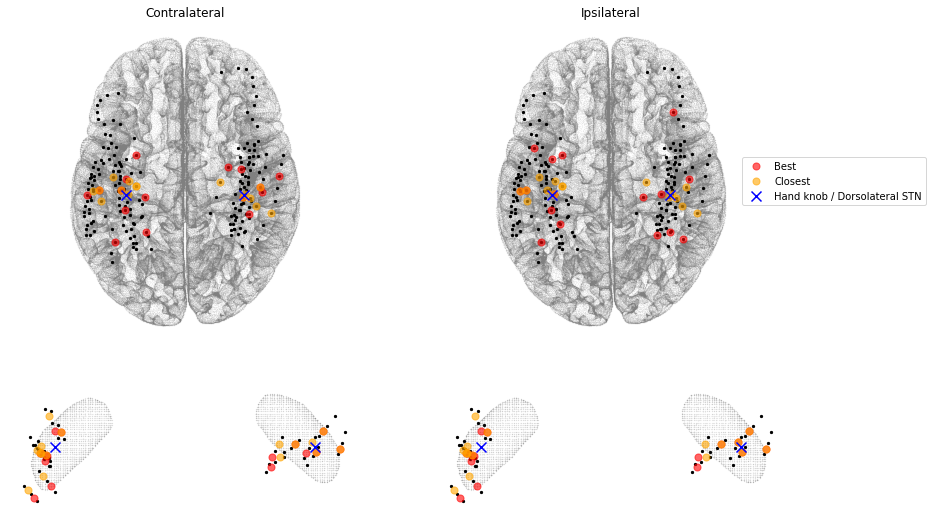

In [70]:
height_STN = 1
height_ECOG = 2.5*height_STN
fig, axes = plt.subplots(2,2, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                         figsize=(14,9))#, dpi=600)
axes[0,0].scatter(x_ecog, y_ecog, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "ECOG"][["x", "y"]])[:,0]
y_ = np.array(df[df["loc"] == "ECOG"][["x", "y"]])[:,1]
axes[0,0].scatter(x_, y_, s=5, c='black')
axes[0,0].scatter(choord_best_ECOG_CON[:,0], choord_best_ECOG_CON[:,1], c='red', s=50, alpha=0.6)
axes[0,0].scatter(choord_closest_ECOG_CON[:,0], choord_closest_ECOG_CON[:,1], c='orange', s=50, alpha=0.6)
axes[0,0].scatter(37, -25, c='blue', s=100, marker='x')
axes[0,0].scatter(-37, -25, c='blue', s=100, marker='x')
axes[0,0].axes.set_aspect('equal', anchor='C')
axes[0,0].axes.set_title('Contralateral')

axes[1,0].axes.set_aspect('equal', anchor='C')

axes[1,0].scatter(x_stn, y_stn, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "STN"][["x", "y"]])[:,0]
y_ = np.array(df[df["loc"] == "STN"][["x", "y"]])[:,1]
axes[1,0].scatter(x_, y_, s=5, c='black')
axes[1,0].scatter(choord_best_STN_CON[:,0], choord_best_STN_CON[:,1], c='red', s=50, alpha=0.6)
axes[1,0].scatter(choord_closest_STN_CON[:,0], choord_closest_STN_CON[:,1], c='orange', s=50, alpha=0.6)
axes[1,0].scatter(12.58, -13.41, c='blue', s=100, marker='x')
axes[1,0].scatter(-12.58, -13.41, c='blue', s=100, marker='x')

axes[0,1].scatter(x_ecog, y_ecog, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "ECOG"][["x", "y"]])[:,0]
y_ = np.array(df[df["loc"] == "ECOG"][["x", "y"]])[:,1]
axes[0,1].scatter(x_, y_, s=5, c='black')
axes[0,1].scatter(choord_best_ECOG_IPS[:,0], choord_best_ECOG_IPS[:,1], c='red', s=50, alpha=0.6, label='Best')
axes[0,1].scatter(choord_closest_ECOG_IPS[:,0], choord_closest_ECOG_IPS[:,1], c='orange', s=50, alpha=0.6, label='Closest')
axes[0,1].scatter(37, -25, c='blue', s=100, marker='x', label='Hand knob / Dorsolateral STN')
axes[0,1].scatter(-37, -25, c='blue', s=100, marker='x')
axes[0,1].axes.set_aspect('equal', anchor='C')
axes[0,1].axes.set_title('Ipsilateral')

axes[1,1].axes.set_aspect('equal', anchor='C')

axes[1,1].scatter(x_stn, y_stn, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "STN"][["x", "y"]])[:,0]
y_ = np.array(df[df["loc"] == "STN"][["x", "y"]])[:,1]
axes[1,1].scatter(x_, y_, s=5, c='black')
axes[1,1].scatter(choord_best_STN_IPS[:,0], choord_best_STN_IPS[:,1], c='red', s=50, alpha=0.6)
axes[1,1].scatter(choord_closest_STN_IPS[:,0], choord_closest_STN_IPS[:,1], c='orange', s=50, alpha=0.6)
axes[1,1].scatter(12.58, -13.41, c='blue', s=100, marker='x')
axes[1,1].scatter(-12.58, -13.41, c='blue', s=100, marker='x')

axes[0,0].set_axis_off()
axes[0,1].set_axis_off()
axes[1,0].set_axis_off()
axes[1,1].set_axis_off()

axes[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
